<a href="https://colab.research.google.com/github/adrianaleticiamartinez/mcd_deep_learning/blob/main/Entrenamiento_GeneradordeCuentos_AdrianaMartinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de un Generador de Cuentos Infantiles con LSTM

### Adriana Leticia Martinez Estrada
###Universidad Panamericana

El notebook desarrolla la implementación de un modelo de **Red Neuronal Recurrente** (RNN) empleando **LSTM** con el propósito de generar relatos infantiles en idioma inglés. El modelo es entrenado utilizando un corpus de texto compuesto por cuentos infantiles, con el propósito de aprender a producir texto a partir de una secuencia inicial dada. El propósito es que, después del proceso de entrenamiento, el modelo pueda producir nuevas secuencias de texto que mantengan el estilo y la coherencia del corpus de entrenamiento.
.

## Objetivos del Notebook
1. **Entrenamiento del modelo LSTM**: Entrenar un modelo LSTM con 180 épocas, utilizando un corpus de cuentos infantiles.
2. **Monitoreo del proceso de entrenamiento**: Graficar el valor de pérdida (*loss*) durante el entrenamiento para analizar la convergencia del modelo.
3. **Generación de texto**: Utilizar el modelo entrenado para generar nuevas secuencias de texto basadas en una secuencia inicial proporcionada.

## Descripción del Proceso

### 1. **Configuración del entorno**
   - Se importan las librerías necesarias: `torch`, `numpy`, `pickle`, y `matplotlib` para la construcción, entrenamiento, y visualización de los resultados del modelo.
   - Se configura el dispositivo de cómputo para aprovechar GPU si está disponible.

### 2. **Parámetros del modelo**
   - `n_hidden`: Número de unidades en las capas ocultas del modelo LSTM (512).
   - `n_layers`: Número de capas en el modelo LSTM (2).
   - `batch_size`: Tamaño de cada lote de datos (128).
   - `seq_length`: Longitud de las secuencias de entrada que el modelo verá durante el entrenamiento (100).
   - `epochs`: Número total de épocas para el entrenamiento (180).
   - `lr`: Tasa de aprendizaje para el optimizador Adam (0.001).
   - `clip`: Valor máximo para los gradientes (5) para evitar la explosión de gradientes.
   - `top_k`: Número de predicciones más probables a considerar al generar texto.

### 3. **Construcción del Modelo LSTM**
   - Se define una clase `LSTM` utilizando `torch.nn.Module`. La clase contiene tres componentes:
     1. Una capa LSTM con las dimensiones configuradas.
     2. Una capa de dropout para regularización.
     3. Una capa densa completamente conectada para generar la predicción del siguiente carácter en la secuencia.

### 4. **Preprocesamiento de Datos**
   - Se implementa una función `one_hot_encode` para codificar los datos en un formato *one-hot*, que es el formato que acepta el modelo LSTM.
   - La función `get_batches` genera los lotes de datos de entrada y sus correspondientes etiquetas.

### 5. **Entrenamiento del Modelo**
   - La función `train` se encarga del entrenamiento del modelo. Se utiliza el optimizador **Adam** y la función de pérdida **CrossEntropyLoss**.
   - Se guarda el valor de pérdida (*loss*) por cada época y se imprime en pantalla.
   - Al final del entrenamiento, los pesos del modelo entrenado se guardan en un archivo `.pth`.

### 6. **Predicción y Pruebas de Generación**
   - La función `predict` genera el siguiente carácter basándose en el estado actual del modelo.
   - La función `sample3` genera una secuencia de texto a partir de una secuencia inicial (por ejemplo, "Once upon a time"). La longitud de la secuencia generada se puede ajustar.

### 7. **Visualización de la Pérdida**
   - Se utiliza `matplotlib` para graficar el valor de la pérdida (*loss*) a lo largo de las épocas de entrenamiento. Esto permite visualizar la convergencia del modelo y detectar posibles problemas, como el sobreajuste.

### 8. **Resultados**
   - El modelo genera nuevas secuencias de texto basadas en la entrada proporcionada por el usuario. A continuación se muestran ejemplos de las secuencias generadas tras 180 épocas de entrenamiento.


## Conclusión

Se ofrece el entrenamiento de un modelo completo para crear texto usando LSTM, que fue entrenado con historias para niños. El modelo puede crear nuevas frases siguiendo una frase inicial dada.

El monitoreo del valor de pérdida durante el entrenamiento permite asegurar que el modelo converge adecuadamente. Además, el modelo es flexible, permitiendo el uso de diferentes configuraciones para la longitud de la secuencia generada y el número de épocas de entrenamiento.

##Consideraciones previas a correr el modelo
Este notebook requiere de los archivos de caracteres. Debido al tamaño del encoded, no ha sido posible cargarlo a algun repositorio remoto. si se requiere el archivo favor de solicitarlo vía correo electrónico a *0268379@up.edu.mx*

In [ ]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import base64
import requests
import pickle

In [ ]:
# Configurar el dispositivo para GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Parámetros del modelo
# ------------------------------
# n_hidden: Número de unidades en las capas ocultas.
n_hidden = 512

# n_layers: Número de capas en el modelo LSTM.
n_layers = 2

# batch_size: Número de ejemplos que se procesan en cada paso de entrenamiento
batch_size = 128

# seq_length: Longitud de las secuencias de entrada (en términos de caracteres) que el modelo verá durante el entrenamiento.
seq_length = 100

# epochs: Número de veces que todo el conjunto de datos será utilizado para entrenar el modelo
#epochs = 60
epochs = 180

# lr (learning rate): Tasa de aprendizaje, determina el tamaño de los pasos que da el modelo para ajustar sus pesos
lr = 0.001

# clip: Valor para "recortar" los gradientes y prevenir que se vuelvan demasiado grandes, lo que puede causar inestabilidad en el entrenamiento.
clip = 5

# top_k: Número de predicciones más probables a considerar al generar nuevo texto. Valores bajos generan texto más "creativo", pero menos coherente.
top_k = 5


In [ ]:
# Definir el modelo LSTM
class LSTM(nn.Module):
    def __init__(self, chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_chars = len(chars)

        self.lstm = nn.LSTM(self.n_chars, n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, self.n_chars)

    def forward(self, x, hidden):
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [ ]:
# Función para one-hot encoder
def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    return one_hot

In [ ]:
# Crear batches para el entrenamiento
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length
    n_batches = len(arr) // batch_size_total
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))

    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n+seq_length]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y


In [ ]:
import matplotlib.pyplot as plt

# Función modificada para entrenar el modelo y almacenar la pérdida en cada época
def train(model, data, epochs=epochs, batch_size=batch_size, seq_length=seq_length, lr=lr, clip=clip):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Lista para almacenar el valor de pérdida en cada época
    all_losses = []

    for epoch in range(epochs):
        h = model.init_hidden(batch_size)  # Inicializa el estado oculto al comienzo de cada época
        epoch_loss = 0
        batch_count = 0

        for x, y in get_batches(data, batch_size, seq_length):
            x = one_hot_encode(x, model.n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            inputs, targets = inputs.to(device), targets.to(device)

            # Desvincular el estado oculto de su historial de gradientes anterior
            h = tuple([each.detach() for each in h])

            model.zero_grad()  # Resetear los gradientes
            output, h = model(inputs, h)
            loss = criterion(output, targets.view(batch_size * seq_length).long())
            loss.backward()

            # Evitar la explosión de gradientes
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            # Acumular el valor de la pérdida
            epoch_loss += loss.item()
            batch_count += 1

        # Promedio de pérdida por época
        avg_loss = epoch_loss / batch_count
        all_losses.append(avg_loss)  # Guardar la pérdida promedio de la época

        print(f"Epoch: {epoch+1}/{epochs}... Loss: {avg_loss}")

    return all_losses  # Devolver todas las pérdidas


In [ ]:
def predict(model, char, device, h=None, top_k=5):

    # Convertir el caracter a su índice entero correspondiente
    x = np.array([[model.char2int[char]]])

    # Codificar el índice entero en formato one-hot
    x = one_hot_encode(x, model.n_chars)

    # Convertir el array de NumPy a un tensor de PyTorch y moverlo al dispositivo especificado (CPU o GPU)
    inputs = torch.from_numpy(x).to(device)

    # Desactivar el cálculo del gradiente para la predicción
    with torch.no_grad():
        out, h = model(inputs, h)

        # Aplicar softmax para obtener las probabilidades de salida
        p = F.softmax(out, dim=1).data.cpu()

        # Obtener los top k caracteres más probables y sus probabilidades
        p, top_ch = p.topk(top_k)

        # Convertir los top k caracteres y probabilidades a arrays de NumPy
        top_ch = top_ch.numpy().squeeze()
        p = p.numpy().squeeze()

        # Elegir aleatoriamente el siguiente carácter de los top k caracteres basándonos en sus probabilidades
        char = np.random.choice(top_ch, p=p/p.sum())

    # Devolver el carácter predicho y el estado oculto actualizado
    return model.int2char[char], h

In [ ]:
def sample3(model, size, device, prime='A', top_k=top_k):
    # Método para generar un nuevo texto basado en una secuencia inicial "prime".
    # Esencialmente, esta función es un ciclo que llama al método "predict" definido anteriormente.
    model.eval()  # Cambiar el modelo a modo de evaluación (eval mode)

    # Calcular el estado oculto del modelo utilizando los caracteres iniciales (prime)
    chars = [ch for ch in prime]  # Crear una lista de los caracteres iniciales
    with torch.no_grad():  # Desactivar el cálculo del gradiente para hacer predicciones
        # Inicializar el estado oculto con ceros al principio. El tamaño del batch es 1
        # ya que deseamos generar una sola secuencia de texto.
        h = model.init_hidden(batch_size=1)

        # Procesar cada carácter de la secuencia inicial prime
        for ch in prime:
            char, h = predict(model, ch, device, h=h, top_k=top_k)

        # Añadir el carácter generado a la secuencia
        chars.append(char)

        # Ahora, se toma el último carácter de la secuencia y se obtiene el siguiente.
        # Este proceso se repite segun lo especificado
        for ii in range(size):
            char, h = predict(model, chars[-1], device, h=h, top_k=top_k)
            chars.append(char)

    # Unir la lista de caracteres
    return ''.join(chars)

In [ ]:
# Importar `chars`
with open('chars60.pkl', 'rb') as f:
    chars = pickle.load(f)

# Importar los diccionarios de mapeo
with open('char2int60.pkl', 'rb') as f:
    char2int = pickle.load(f)

with open('int2char60.pkl', 'rb') as f:
    int2char = pickle.load(f)

with open('encoded60.pkl', 'rb') as f:
    encoded = pickle.load(f)

In [ ]:
# Configurar el modelo
model = LSTM(chars, n_hidden=n_hidden, n_layers=n_layers).to(device)
model.int2char = int2char
model.char2int = char2int

In [ ]:
# Entrenar el modelo y obtener las pérdidas por época
losses = train(model, encoded)

Epoch: 1/180... Loss: 1.9251654581522315
Epoch: 2/180... Loss: 1.444470554925921
Epoch: 3/180... Loss: 1.3444659283223828
Epoch: 4/180... Loss: 1.2954201129858425
Epoch: 5/180... Loss: 1.2653237344774049
Epoch: 6/180... Loss: 1.2445989227265082
Epoch: 7/180... Loss: 1.2291445885790753
Epoch: 8/180... Loss: 1.217017750119387
Epoch: 9/180... Loss: 1.2067412267041595
Epoch: 10/180... Loss: 1.198377799032925
Epoch: 11/180... Loss: 1.1913383598620064
Epoch: 12/180... Loss: 1.184775490933873
Epoch: 13/180... Loss: 1.1791734293345666
Epoch: 14/180... Loss: 1.1741420033577834
Epoch: 15/180... Loss: 1.1696330558075028
Epoch: 16/180... Loss: 1.1655642820687706
Epoch: 17/180... Loss: 1.161924142637599
Epoch: 18/180... Loss: 1.1584865908151276
Epoch: 19/180... Loss: 1.1553783772585537
Epoch: 20/180... Loss: 1.15236800700165
Epoch: 21/180... Loss: 1.1494394191663166
Epoch: 22/180... Loss: 1.1469387024902133
Epoch: 23/180... Loss: 1.144500800456213
Epoch: 24/180... Loss: 1.1421707981220623
Epoch: 25

In [ ]:
# Guardar el modelo entrenado
model_save_path = "lstm_cuentos_infantiles_180epoch.pth"
torch.save(model.state_dict(), model_save_path)

In [ ]:
# prime: Texto inicial con el que comienza la generación de nuevo texto.
# ---- Cambiar aqui para pruebas c: ----
prime = "Once upon a time"

In [ ]:
# Generar un cuento
#generated_text = sample(model, 500)
generated_text = sample3(model, 1000, device, prime=prime)
print(generated_text)

Once upon a time."
"I am ashamed of," said Momotaro.
His face was suddenly charged, and set his shining forehead to his head. "I should have been a pardon on that town that was the same."
"Yes, I was not so sorry. The mischief ought to have seen; but that was a great pleasure to me in some subject of his sensation and transformed into a trick. He started another. If you were the same permanent man to the means of allowing to be angry in my heart, I had no more trickle of adventure for him, and I was angry with me a little. The mischief stepped to the courtyard at the same time, and watched me there. I was thinking of it, and that how much the master was to say to you," said Mr. Courtes, "a man which I want your father."
"This is the same with a starved flower with a great delight and annoyance," said the patient.
"I have been so terrible there, that your part were the beloved old four children," said the crash. "I am sure it is the people in the world; I shall still see this. That's th

### Gráfica del Entrenamiento

La siguiente gráfica muestra la pérdida (*loss*) en cada época durante el entrenamiento del modelo:

La tendencia descendente indica que el modelo está mejorando con el tiempo, ajustando sus parámetros para reducir el error en cada iteración.




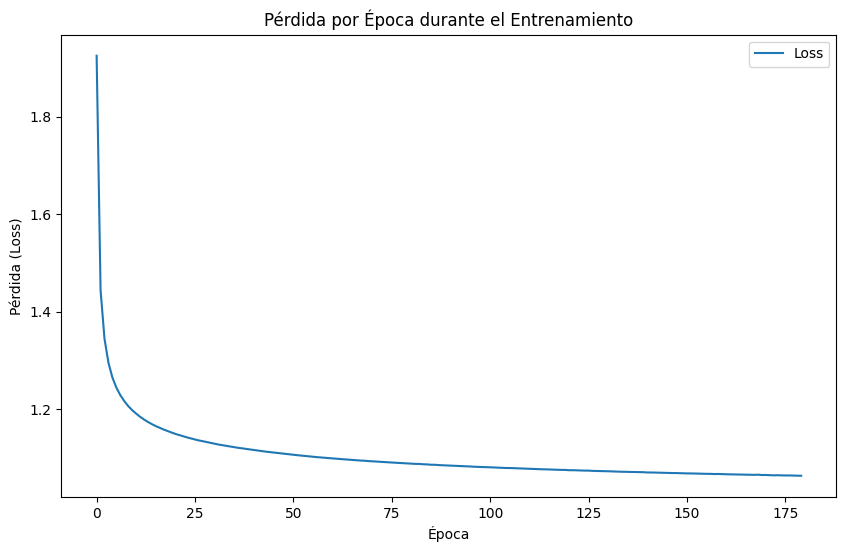

In [ ]:
import matplotlib.pyplot as plt

# Graficar las pérdidas por época
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Loss")
plt.title("Pérdida por Época durante el Entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.show()